## Configuration

In [1]:
#IPython extension to reload modules before executing user code.
#'autoreload' reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import gpustat

#select the best free GPU on the nvidia card
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
bestGPU = 0

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)

setGPU: Setting GPU to: 0


In [3]:
#!pip install -q keract 
import collections
import numpy
from keract import get_activations
import keras
from keras import backend as K
from keras import optimizers, regularizers
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10 # we can use also cifar100
from keras.layers import Input, BatchNormalization, AveragePooling2D, ZeroPadding2D, LeakyReLU, GlobalAveragePooling2D, Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model, Model
from keras.regularizers import l2
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import scipy
import sklearn
import sklearn.metrics
import time
from IPython.display import SVG

Using TensorFlow backend.


In [4]:
# import of the models
import sys
sys.path.insert(0, "../")
from models import VGG16, VGG16_Vanilla, VGG16_beta,VGG16_Vanilla_beta
from data_utils import import_cifar

In [5]:
# LOAD DATABase
num_classes = 10
(x_train, y_train), (x_test, y_test) = import_cifar(num_classes)

### Loading models

In [6]:
# LOAD huge MODELS
modelA = VGG16_Vanilla(input_shape=(32,32,3), num_classes=10) #without Weight Decay
modelB = VGG16_Vanilla_beta(input_shape=(32,32,3), num_classes=10) #without Weight Decay but batchNorm before activation
modelC = VGG16_beta(input_shape=(32,32,3), num_classes=10, weight_decay=0.005) #with Weight Decay, and batchNorm before activation
modelD = VGG16_Vanilla_beta(input_shape=(32,32,3), num_classes=10) #without Weight Decay, but batchNorm before activation and with layca

modelA.load_weights("../weights/1/vgg16_vanilla/final/weights-final.hdf5")
modelB.load_weights("../weights/1/vgg16_vanilla_beta/final/weights-final.hdf5")
modelC.load_weights("../weights/1/vgg16_beta/final/weights-final.hdf5")
modelD.load_weights("../weights/1/vgg16_vanilla_layca/final/weights-final.hdf5")

sgd = optimizers.SGD(lr=0.2, momentum=0.9, nesterov=True)
modelA.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
modelB.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
modelC.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
modelD.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [7]:
# EVALUATION
# Final evaluation of the models
scoresA = modelA.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresA[0])
print('Test accuracy:', scoresA[1])
print("%.2f%% : Model A without Weightdecay CNN Error" % (100-scoresA[1]*100))
scoresB = modelB.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresB[0])
print('Test accuracy:', scoresB[1])
print("%.2f%% : Model B without Weightdecay with BatchNorm before activation CNN Error" % (100-scoresB[1]*100))
scoresC = modelC.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresC[0])
print('Test accuracy:', scoresC[1])
print("%.2f%% : Model C without Weightdecay with layca CNN Error" % (100-scoresC[1]*100))
scoresD = modelD.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresD[0])
print('Test accuracy:', scoresD[1])
print("%.2f%% : Model D with Weightdecay CNN Error"  % (100-scoresD[1]*100))

10000/10000 [==============================] - 10s 990us/step
Test loss: 1.568993224811554
Test accuracy: 0.7135
28.65% : Model A without Weightdecay CNN Error
10000/10000 [==============================] - 3s 349us/step
Test loss: 0.7410675114631653
Test accuracy: 0.8364
16.36% : Model B without Weightdecay with BatchNorm before activation CNN Error
10000/10000 [==============================] - 4s 351us/step
Test loss: 0.728547889328003
Test accuracy: 0.8614
13.86% : Model C without Weightdecay with layca CNN Error
10000/10000 [==============================] - 3s 320us/step
Test loss: 0.6406159735679626
Test accuracy: 0.8728
12.72% : Model D with Weightdecay CNN Error


### Mutual Information
On regarde l'information mutuelle arrondie à des binaires.

In [8]:
# On regarde l'activation des pairs de neurones pour un echantillon test pris au hasard
Echantillon = []
nombreDImagesDActivation = 2000
choix = numpy.random.choice(x_test.shape[0], nombreDImagesDActivation)
Echantillon = x_test[choix, :, : , :]

#Echantillon = [x_test[0], x_test[1], x_test[2], x_test[3], x_test[4], x_test[5], x_test[6], x_test[7], x_test[8], x_test[9], x_test[10], x_test[11], x_test[12], x_test[13]]
IMA = get_activations(modelA, Echantillon)
IMB = get_activations(modelB, Echantillon)
IMC = get_activations(modelC, Echantillon)
IMD = get_activations(modelD, Echantillon)

In [9]:
# on affiche les noms des differentes couches
'''
print(IMA.keys())
print('\n')
print(IMB.keys())
print('\n')
print(IMC.keys())
print('\n')
print(IMD.keys())
'''

"\nprint(IMA.keys())\nprint('\n')\nprint(IMB.keys())\nprint('\n')\nprint(IMC.keys())\nprint('\n')\nprint(IMD.keys())\n"

In [10]:
modelA.summary()
modelB.summary()
modelC.summary()
modelD.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

In [11]:
List_of_Layers_A = [
'conv2d_1/BiasAdd:0', 
'conv2d_2/BiasAdd:0',
'max_pooling2d_1/MaxPool:0',
'conv2d_3/BiasAdd:0', 
'conv2d_4/BiasAdd:0', 
'max_pooling2d_2/MaxPool:0',
'conv2d_5/BiasAdd:0', 
'conv2d_6/BiasAdd:0',  
'conv2d_7/BiasAdd:0', 
'max_pooling2d_3/MaxPool:0', 
'conv2d_8/BiasAdd:0',  
'conv2d_9/BiasAdd:0', 
'conv2d_10/BiasAdd:0', 
'max_pooling2d_4/MaxPool:0', 
'conv2d_11/BiasAdd:0',    
'conv2d_12/BiasAdd:0',
'conv2d_13/BiasAdd:0', 
'max_pooling2d_5/MaxPool:0', 
'dense_1/BiasAdd:0', 
'dense_2/BiasAdd:0', 
 ]

List_of_Layers_B = [
'conv2d_14/BiasAdd:0', 
'conv2d_15/BiasAdd:0',
'max_pooling2d_6/MaxPool:0',
'conv2d_16/BiasAdd:0', 
'conv2d_17/BiasAdd:0', 
'max_pooling2d_7/MaxPool:0',
'conv2d_18/BiasAdd:0', 
'conv2d_19/BiasAdd:0',  
'conv2d_20/BiasAdd:0', 
'max_pooling2d_8/MaxPool:0', 
'conv2d_21/BiasAdd:0',  
'conv2d_22/BiasAdd:0', 
'conv2d_23/BiasAdd:0', 
'max_pooling2d_9/MaxPool:0', 
'conv2d_24/BiasAdd:0',    
'conv2d_25/BiasAdd:0',
'conv2d_26/BiasAdd:0', 
'max_pooling2d_10/MaxPool:0', 
'dense_3/BiasAdd:0', 
'dense_4/BiasAdd:0', 
 ]

List_of_Layers_C = [
'conv2d_27/BiasAdd:0', 
'conv2d_28/BiasAdd:0',
'max_pooling2d_11/MaxPool:0',
'conv2d_29/BiasAdd:0', 
'conv2d_30/BiasAdd:0', 
'max_pooling2d_12/MaxPool:0',
'conv2d_31/BiasAdd:0', 
'conv2d_32/BiasAdd:0',  
'conv2d_33/BiasAdd:0', 
'max_pooling2d_13/MaxPool:0', 
'conv2d_34/BiasAdd:0',  
'conv2d_35/BiasAdd:0', 
'conv2d_36/BiasAdd:0', 
'max_pooling2d_14/MaxPool:0', 
'conv2d_37/BiasAdd:0',    
'conv2d_38/BiasAdd:0',
'conv2d_39/BiasAdd:0', 
'max_pooling2d_15/MaxPool:0', 
'dense_5/BiasAdd:0', 
'dense_6/BiasAdd:0', 
 ]

List_of_Layers_D = [
'conv2d_40/BiasAdd:0', 
'conv2d_41/BiasAdd:0',
'max_pooling2d_16/MaxPool:0',
'conv2d_42/BiasAdd:0', 
'conv2d_43/BiasAdd:0', 
'max_pooling2d_17/MaxPool:0',
'conv2d_44/BiasAdd:0', 
'conv2d_45/BiasAdd:0',  
'conv2d_46/BiasAdd:0', 
'max_pooling2d_18/MaxPool:0', 
'conv2d_47/BiasAdd:0',  
'conv2d_48/BiasAdd:0', 
'conv2d_49/BiasAdd:0', 
'max_pooling2d_19/MaxPool:0', 
'conv2d_50/BiasAdd:0',    
'conv2d_51/BiasAdd:0',
'conv2d_52/BiasAdd:0', 
'max_pooling2d_20/MaxPool:0', 
'dense_7/BiasAdd:0', 
'dense_8/BiasAdd:0', 
 ]


 Model A :

couche : conv2d_1/BiasAdd:0
couche : conv2d_2/BiasAdd:0
couche : max_pooling2d_1/MaxPool:0
couche : conv2d_3/BiasAdd:0
couche : conv2d_4/BiasAdd:0
couche : max_pooling2d_2/MaxPool:0
couche : conv2d_5/BiasAdd:0
couche : conv2d_6/BiasAdd:0
couche : conv2d_7/BiasAdd:0
couche : max_pooling2d_3/MaxPool:0
couche : conv2d_8/BiasAdd:0
couche : conv2d_9/BiasAdd:0
couche : conv2d_10/BiasAdd:0
couche : max_pooling2d_4/MaxPool:0
couche : conv2d_11/BiasAdd:0
couche : conv2d_12/BiasAdd:0
couche : conv2d_13/BiasAdd:0
couche : max_pooling2d_5/MaxPool:0
couche : dense_1/BiasAdd:0
couche : dense_2/BiasAdd:0

 Model B :

couche : conv2d_14/BiasAdd:0
couche : conv2d_15/BiasAdd:0
couche : max_pooling2d_6/MaxPool:0
couche : conv2d_16/BiasAdd:0
couche : conv2d_17/BiasAdd:0
couche : max_pooling2d_7/MaxPool:0
couche : conv2d_18/BiasAdd:0
couche : conv2d_19/BiasAdd:0
couche : conv2d_20/BiasAdd:0
couche : max_pooling2d_8/MaxPool:0
couche : conv2d_21/BiasAdd:0
couche : conv2d_22/BiasAdd:0
couche : co

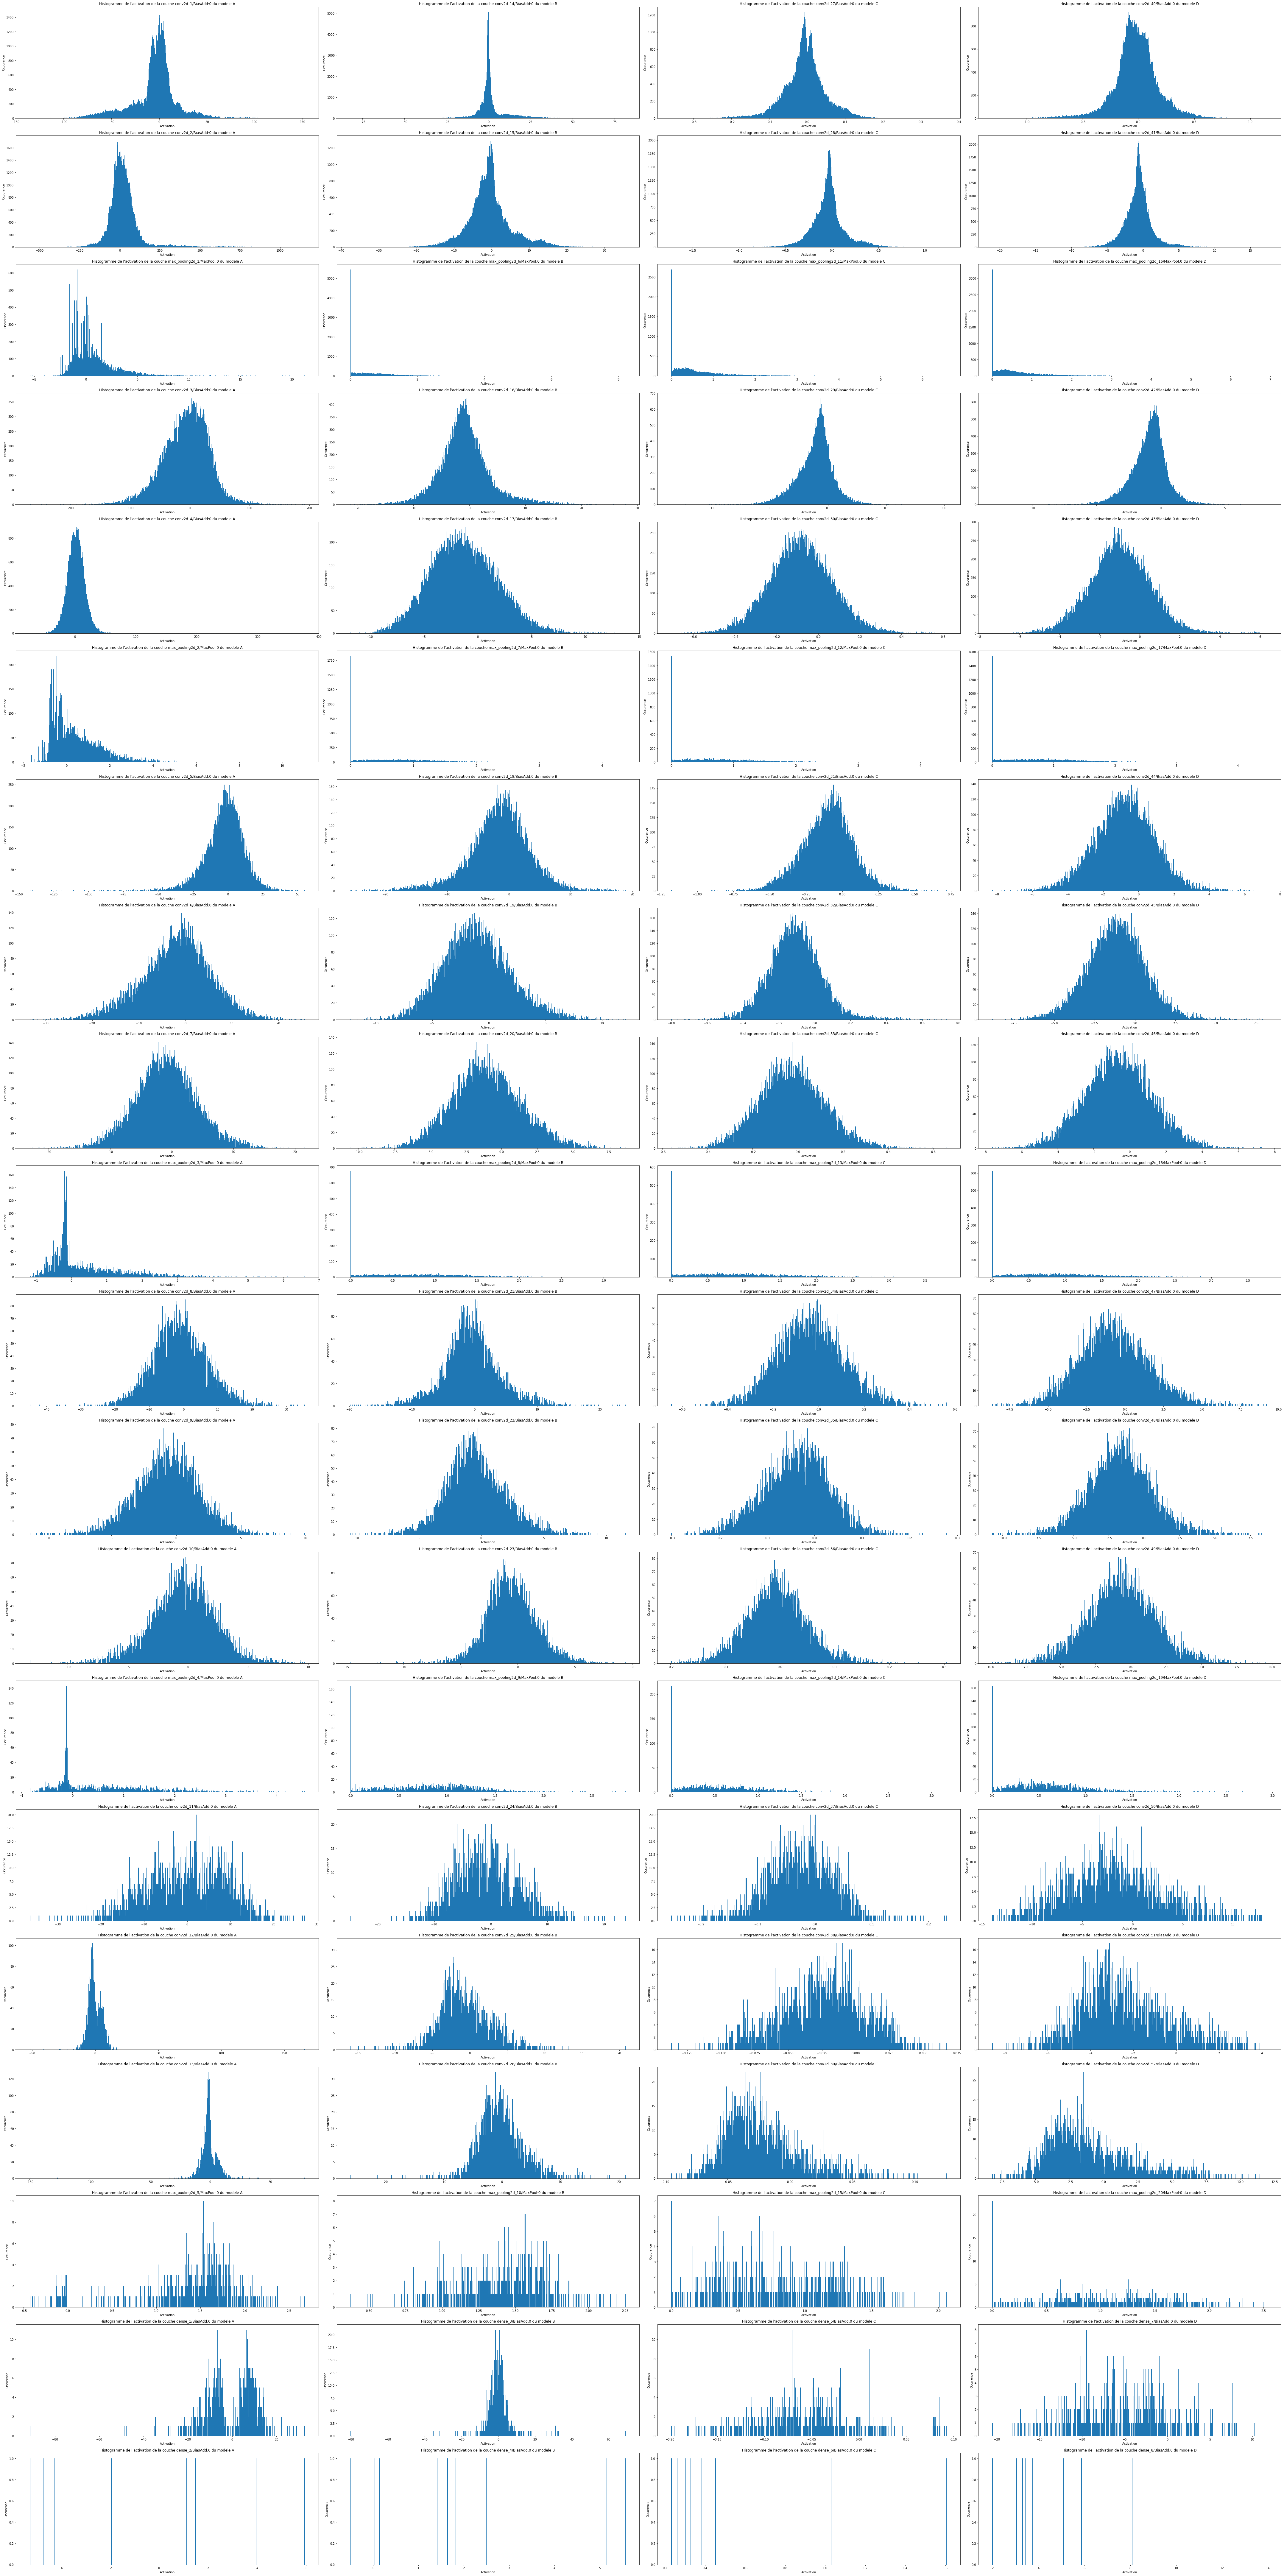

In [12]:
NumberOfModels = 4
NumberOfLayers = 20

histogrammeMatrixA = []*NumberOfLayers
histogrammeMatrixB = []*NumberOfLayers
histogrammeMatrixC = []*NumberOfLayers
histogrammeMatrixD = []*NumberOfLayers

fig = plt.figure(figsize=(60, 300))
#plt.ylim(top=1000)

print('\n Model A :\n')
i = 1
for layer in List_of_Layers_A:
    #nom de la couche
    print('couche :', str(layer))
    if "dropout" not in str(layer): 
        for activation in IMA[layer]:
            activation = activation.flatten()
        #plot
        plt.subplot(len(IMA), 4, i)
        plt.hist(activation, bins=500)
        plt.xlabel('Activation')
        plt.ylabel('Occurence')
        plt.title('Histogramme de l\'activation de la couche '+ str(layer)+ ' du modele A')
        plt.tight_layout()
        i = i + NumberOfModels
        
print('\n Model B :\n')
i = 2
for layer in List_of_Layers_B:
    #nom de la couche
    print('couche :', str(layer))
    if "dropout" not in str(layer): 
        for activation in IMB[layer]:
            activation = activation.flatten()
        #plot
        plt.subplot(len(IMA), 4, i)
        plt.hist(activation, bins=500)
        plt.xlabel('Activation')
        plt.ylabel('Occurence')
        plt.title('Histogramme de l\'activation de la couche '+ str(layer)+ ' du modele B')
        plt.tight_layout()
        i = i + NumberOfModels
        
print('\n Model C :\n')
i = 3
for layer in List_of_Layers_C:
    #nom de la couche
    print('couche :', str(layer))
    if "dropout" not in str(layer): 
        for activation in IMC[layer]:
            activation = activation.flatten()
        #plot
        plt.subplot(len(IMA), 4, i)
        plt.hist(activation, bins=500)
        plt.xlabel('Activation')
        plt.ylabel('Occurence')
        plt.title('Histogramme de l\'activation de la couche '+ str(layer)+ ' du modele C')
        plt.tight_layout()
        i = i + NumberOfModels
        
print('\n Model D :\n')
i = 4
for layer in List_of_Layers_D:
    #nom de la couche
    print('couche :', str(layer))
    if "dropout" not in str(layer): 
        for activation in IMD[layer]:
            activation = activation.flatten()
        #plot
        plt.subplot(len(IMA), 4, i)
        plt.hist(activation, bins=500)
        plt.xlabel('Activation')
        plt.ylabel('Occurence')
        plt.title('Histogramme de l\'activation de la couche '+ str(layer)+ ' du modele D')
        plt.tight_layout()
        i = i + NumberOfModels
        
plt.show()
fig.savefig('figures/layer_activation_normal.png', dpi=100)